# TP1 ACN 2025 – Simulación AEP
Este notebook usa `aep_sim.py` y sigue el estilo de las clases (NumPy, Monte Carlo, matplotlib).

## Contenidos
1. Parámetros y funciones auxiliares
2. Simulación base (sin eventos de clima)
3. Experimentos para distintos $\lambda\in\{0.02, 0.1, 0.2, 0.5, 1\}$
4. Día ventoso (interrupciones 10%)
5. Cierre sorpresivo de 30 minutos
6. Visualizaciones (timeline de aterrizajes, evolución de distancias)
7. Resumen de métricas con error de estimación


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import aep_sim; reload(aep_sim)
from aep_sim import SimulationConfig, AEPSimulator, run_batch, ideal_time_minutes
ideal_time_minutes()

23.4

### Simulación base
Corramos una simulación con $\lambda=0.1$ para visualizar resultados.

In [20]:
cfg = SimulationConfig(lambda_per_min=0.1, seed=42)
sim = AEPSimulator(cfg)
out = sim.run()
out.landed, out.diverted, out.avg_delay_minutes

(115, 0, 2.7304347826086968)

### Timeline de aterrizajes

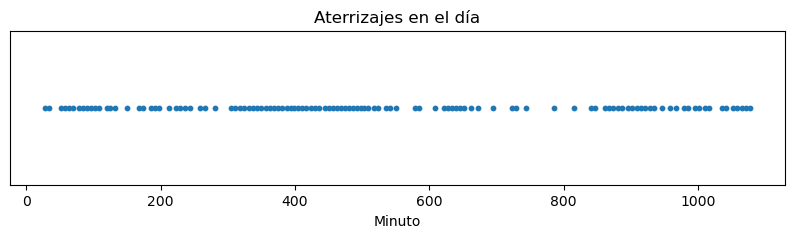

In [21]:
plt.figure(figsize=(10,2))
y = np.zeros(len(out.timeline_landings))
plt.scatter(out.timeline_landings, y, s=10)
plt.yticks([]); plt.xlabel('Minuto'); plt.title('Aterrizajes en el día')
plt.show()

Trayectorias distancia–tiempo

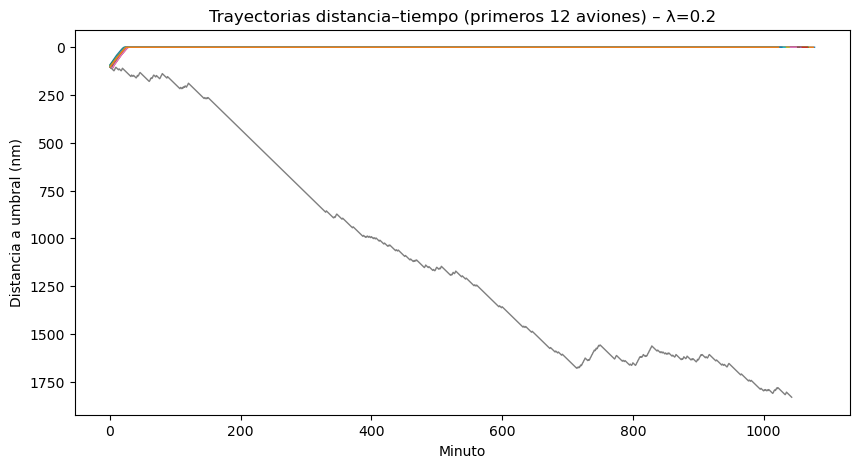

In [22]:
from aep_sim import OPERATION_MINUTES, desired_speed_max_for_distance_nm

cfg = SimulationConfig(lambda_per_min=0.2, seed=777)
sim = AEPSimulator(cfg)

# Logs por minuto: {id: [dist_t0, dist_t1, ...]}
dist_log = {}
status_log = {}

for minute in range(OPERATION_MINUTES):
    # registrar estado ANTES del paso (como sueles hacer en caminatas aleatorias)
    for a in sim.aircrafts:
        if a.id not in dist_log:
            dist_log[a.id] = []
            status_log[a.id] = []
        dist_log[a.id].append(a.distance_nm)
        status_log[a.id].append(a.status)
    # avanzar 1 minuto
    sim.step(minute)

# Graficar las primeras N trayectorias
N = 12
plt.figure(figsize=(10,5))
for aid in sorted(dist_log.keys())[:N]:
    series = dist_log[aid]
    plt.plot(series, linewidth=1)
plt.gca().invert_yaxis()  # 100 → 0 (más intuitivo al acercar)
plt.xlabel("Minuto")
plt.ylabel("Distancia a umbral (nm)")
plt.title(f"Trayectorias distancia–tiempo (primeros {N} aviones) – λ=0.2")
plt.show()


Experimentos por lotes (λ ∈ {0.02, 0.1, 0.2, 0.5, 1}) con medias + error estándar

In [23]:
import numpy as np
from importlib import reload
import aep_sim; reload(aep_sim)
from aep_sim import SimulationConfig, AEPSimulator

def run_batch_like_class(lams, reps=30, seed=123, windy_day=False, closure=None):
    rng = np.random.default_rng(seed)
    rows = []
    for lam in lams:
        landed, diverted, delay, goas = [], [], [], []
        for r in range(reps):
            cfg = SimulationConfig(lambda_per_min=lam,
                                   windy_day=windy_day,
                                   closure_window=closure,
                                   seed=int(rng.integers(0, 1e9)))
            sim = AEPSimulator(cfg)
            out = sim.run()
            landed.append(out.landed)
            diverted.append(out.diverted)
            goas.append(out.go_arounds)
            delay.append(np.mean(out.delays) if out.delays else 0.0)
        def mean(x): return float(np.mean(x))
        def se(x): return float(np.std(x, ddof=1)/np.sqrt(len(x)))
        rows.append({
            "lambda": lam,
            "landed_mean": mean(landed),   "landed_se": se(landed),
            "diverted_mean": mean(diverted),"diverted_se": se(diverted),
            "avg_delay_mean": mean(delay), "avg_delay_se": se(delay),
            "go_around_mean": mean(goas),  "go_around_se": se(goas),
        })
    return rows

lams = [0.02, 0.1, 0.2, 0.5, 1.0]
res_normal = run_batch_like_class(lams, reps=30, seed=2025)
for row in res_normal:
    print(row)


{'lambda': 0.02, 'landed_mean': 21.033333333333335, 'landed_se': 0.9630928785534169, 'diverted_mean': 0.0, 'diverted_se': 0.0, 'avg_delay_mean': -1.030510539442063, 'avg_delay_se': 0.05394051340602523, 'go_around_mean': 3.9, 'go_around_se': 0.700328330224433}
{'lambda': 0.1, 'landed_mean': 104.36666666666666, 'landed_se': 1.6556995488821584, 'diverted_mean': 0.0, 'diverted_se': 0.0, 'avg_delay_mean': 2.190506439186171, 'avg_delay_se': 0.256225847736842, 'go_around_mean': 231.93333333333334, 'go_around_se': 21.696704200870617}
{'lambda': 0.2, 'landed_mean': 169.2, 'landed_se': 0.393627398354881, 'diverted_mean': 0.0, 'diverted_se': 0.0, 'avg_delay_mean': 9.397277809164843, 'avg_delay_se': 0.5833877910340074, 'go_around_mean': 18217.366666666665, 'go_around_se': 1354.4653273340707}
{'lambda': 0.5, 'landed_mean': 173.26666666666668, 'landed_se': 0.2991687077700679, 'diverted_mean': 0.0, 'diverted_se': 0.0, 'avg_delay_mean': 0.8554785651492561, 'avg_delay_se': 0.06872627168549343, 'go_arou

Distribucion de atrasos

Atraso medio: 0.6057142857142869


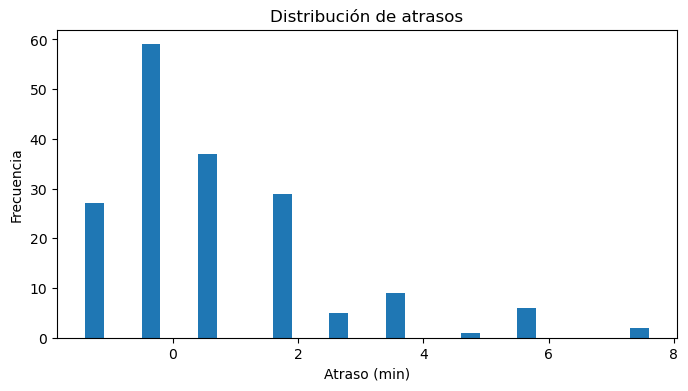

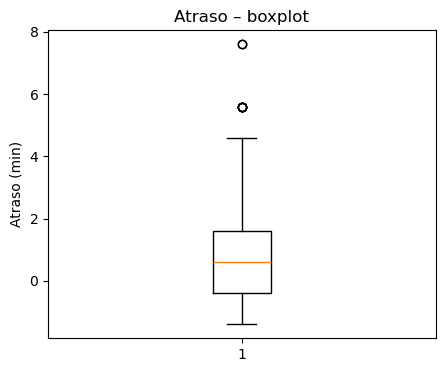

In [24]:
cfg = SimulationConfig(lambda_per_min=0.5, seed=2026)
sim = AEPSimulator(cfg)
out = sim.run()

delays = np.array(out.delays)  # en minutos
print("Atraso medio:", delays.mean() if len(delays) else 0.0)

plt.figure(figsize=(8,4))
plt.hist(delays, bins=30)
plt.xlabel("Atraso (min)")
plt.ylabel("Frecuencia")
plt.title("Distribución de atrasos")
plt.show()

plt.figure(figsize=(5,4))
plt.boxplot(delays, vert=True)
plt.ylabel("Atraso (min)")
plt.title("Atraso – boxplot")
plt.show()


Porababilidad de 5 arribos en una hora

In [25]:
import numpy as np
from math import comb, exp, factorial

# Parámetros "modo clase"
n = 60              # 60 minutos
p = 1/60            # prob. por minuto
k = 5               # queremos 5 arribos en una hora

# Analítico: Binomial(n=60, p=1/60)
binom_pmf = comb(n, k) * (p**k) * ((1-p)**(n-k))

# Aprox Poisson con lambda=1 por hora
lam = 1.0
poiss_pmf = exp(-lam) * (lam**k) / factorial(k)

# Monte Carlo simple
rng = np.random.default_rng(123)
N = 200_000
samples = rng.binomial(n=n, p=p, size=N)
mc_est = np.mean(samples == k)
mc_se  = np.sqrt(mc_est*(1-mc_est)/N)  # error estándar

print(f"P(X=5) Binomial exacta = {binom_pmf:.6f}")
print(f"P(X=5) Poisson(1)      = {poiss_pmf:.6f}")
print(f"P(X=5) Monte Carlo      = {mc_est:.6f} ± {1.96*mc_se:.6f} (95% IC)")


P(X=5) Binomial exacta = 0.002787
P(X=5) Poisson(1)      = 0.003066
P(X=5) Monte Carlo      = 0.002960 ± 0.000238 (95% IC)


### Experimentos para varios $\lambda$ (promedios y error estándar)

In [26]:
lams = [0.02, 0.1, 0.2, 0.5, 1.0]
res = run_batch(lams, reps=20, seed=123)
res

{0.02: {'landed_mean': 22.45,
  'landed_se': 1.129683234595573,
  'diverted_mean': 0.0,
  'diverted_se': 0.0,
  'avg_delay_mean': -1.0012104926707317,
  'avg_delay_se': 0.05425997800085318,
  'go_around_mean': 4.15,
  'go_around_se': 0.7081294856317258},
 0.1: {'landed_mean': 104.3,
  'landed_se': 1.6624332198696932,
  'diverted_mean': 0.0,
  'diverted_se': 0.0,
  'avg_delay_mean': 2.2353357903130426,
  'avg_delay_se': 0.269923686699631,
  'go_around_mean': 225.6,
  'go_around_se': 18.937348227635695},
 0.2: {'landed_mean': 167.7,
  'landed_se': 0.47627944031120834,
  'diverted_mean': 0.0,
  'diverted_se': 0.0,
  'avg_delay_mean': 8.58389889008795,
  'avg_delay_se': 0.5300631476180053,
  'go_around_mean': 18161.55,
  'go_around_se': 1826.5426723947478},
 0.5: {'landed_mean': 173.9,
  'landed_se': 0.2982404540317303,
  'diverted_mean': 0.0,
  'diverted_se': 0.0,
  'avg_delay_mean': 0.7195613112276931,
  'avg_delay_se': 0.0675667741684387,
  'go_around_mean': 200187.7,
  'go_around_se': 

### Día ventoso (10% interrupciones por avión)

In [27]:
res_windy = run_batch(lams, reps=20, seed=123, windy_day=True)
res_windy

{0.02: {'landed_mean': 22.1,
  'landed_se': 1.090388631828603,
  'diverted_mean': 0.0,
  'diverted_se': 0.0,
  'avg_delay_mean': -0.8512645817437161,
  'avg_delay_se': 0.08170943824692864,
  'go_around_mean': 6.15,
  'go_around_se': 0.7155233638467203},
 0.1: {'landed_mean': 103.9,
  'landed_se': 1.36478261234065,
  'diverted_mean': 0.0,
  'diverted_se': 0.0,
  'avg_delay_mean': 3.787840662819472,
  'avg_delay_se': 0.3388450371580886,
  'go_around_mean': 289.75,
  'go_around_se': 21.94800974072472},
 0.2: {'landed_mean': 152.55,
  'landed_se': 0.8567840727793794,
  'diverted_mean': 0.0,
  'diverted_se': 0.0,
  'avg_delay_mean': 11.227482803568964,
  'avg_delay_se': 0.4059956682128775,
  'go_around_mean': 26261.5,
  'go_around_se': 1758.5594186570347},
 0.5: {'landed_mean': 155.2,
  'landed_se': 0.5875909783980152,
  'diverted_mean': 0.0,
  'diverted_se': 0.0,
  'avg_delay_mean': 5.7603835377046675,
  'avg_delay_se': 0.2016390771732807,
  'go_around_mean': 205943.35,
  'go_around_se': 2

Día ventoso + cierre sorpresivo

In [ ]:
# Día ventoso (10% interrupciones)
res_windy = run_batch_like_class(lams, reps=30, seed=2025, windy_day=True)
print("Windy day:", res_windy)

# Cierre sorpresivo 12:00–12:30 (min 360–390)
res_closure = run_batch_like_class(lams, reps=30, seed=2025, closure=(360,390))
print("Closure:", res_closure)


Windy day: [{'lambda': 0.02, 'landed_mean': 21.066666666666666, 'landed_se': 0.9766625475571215, 'diverted_mean': 0.0, 'diverted_se': 0.0, 'avg_delay_mean': -0.9558528446495071, 'avg_delay_se': 0.07412634929872366, 'go_around_mean': 6.0, 'go_around_se': 0.8905635565617211}, {'lambda': 0.1, 'landed_mean': 105.13333333333334, 'landed_se': 1.9050648363379503, 'diverted_mean': 0.0, 'diverted_se': 0.0, 'avg_delay_mean': 4.152123863386202, 'avg_delay_se': 0.4374178334383816, 'go_around_mean': 313.8666666666667, 'go_around_se': 33.97323941234604}, {'lambda': 0.2, 'landed_mean': 153.8, 'landed_se': 0.6563570657052071, 'diverted_mean': 0.0, 'diverted_se': 0.0, 'avg_delay_mean': 11.91003588856044, 'avg_delay_se': 0.3644306875049372, 'go_around_mean': 25658.4, 'go_around_se': 1497.4708045817497}, {'lambda': 0.5, 'landed_mean': 155.0, 'landed_se': 0.5360562674188974, 'diverted_mean': 0.0, 'diverted_se': 0.0, 'avg_delay_mean': 5.779922024955406, 'avg_delay_se': 0.15043339567361702, 'go_around_mean'

### Cierre sorpresivo de 30 min
Ejemplo: cierre de 12:00 a 12:30 → minutos 360 a 390.

In [ ]:
res_closure = run_batch(lams, reps=20, seed=123, closure_window=(360, 390))
res_closure

{0.02: {'landed_mean': 22.45,
  'landed_se': 1.129683234595573,
  'diverted_mean': 0.0,
  'diverted_se': 0.0,
  'avg_delay_mean': -0.5865469146791484,
  'avg_delay_se': 0.12343137916405145,
  'go_around_mean': 4.9,
  'go_around_se': 0.8822817308726159},
 0.1: {'landed_mean': 104.3,
  'landed_se': 1.6624332198696932,
  'diverted_mean': 0.0,
  'diverted_se': 0.0,
  'avg_delay_mean': 3.6488887212584387,
  'avg_delay_se': 0.4494281915768047,
  'go_around_mean': 285.0,
  'go_around_se': 30.466202153931334},
 0.2: {'landed_mean': 162.0,
  'landed_se': 0.6882472016116853,
  'diverted_mean': 0.0,
  'diverted_se': 0.0,
  'avg_delay_mean': 9.616825328959173,
  'avg_delay_se': 0.6350320419340368,
  'go_around_mean': 21519.3,
  'go_around_se': 1860.8749372553932},
 0.5: {'landed_mean': 168.6,
  'landed_se': 0.5591346697776559,
  'diverted_mean': 0.0,
  'diverted_se': 0.0,
  'avg_delay_mean': 1.9240384221001345,
  'avg_delay_se': 0.12876474535735333,
  'go_around_mean': 203953.8,
  'go_around_se': 

## TODOs sugeridos (para llegar al 100% del enunciado)
- Refinar la lógica de **reinserción** tras go-around: buscar explícitamente el primer hueco ≥10 min y forzar el giro cuando se cumpla y la distancia sea >5 mn.
- Visualización de **trayectorias** (distancia vs. tiempo) para varios aviones en un mismo gráfico, coloreando por estado (approach, go-around, landed, diverted).
- Cálculo de **probabilidad de 5 arribos en una hora** para el caso de $\lambda$ que implica 1 avión/hora (comparar con Poisson/Binomial) y validarlo por simulación.
- Medir **atraso promedio** con distribución completa (boxplots) y su error de estimación (IC 95%).
